## Airlines lose tens of billions of dollars annually due to delays. Can we predict the number of flights at risk a month in advance so they can make be better prepared? 
## Additionally, can we understand what drives said predictions? 
#### To begin we need to explore our data: 

In [2]:
import pandas as pd 
import numpy as np

np.random.seed(42)

DATA_PATH = '../Airline_Delay_Cause.csv'  # Find the dataset here: https://www.kaggle.com/datasets/sriharshaeedala/airline-delay
df = pd.read_csv(DATA_PATH)
df.head() 

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",89.0,13.0,2.25,1.60,...,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",62.0,10.0,1.97,0.04,...,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,10.0,2.73,1.18,...,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",66.0,12.0,3.69,2.27,...,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",92.0,22.0,7.76,0.00,...,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


In [3]:
df.shape

(171666, 21)

In [4]:
df.columns

Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
       'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')

#### Some columns have unclear meanings so I will briefly explain each:
* arr_flights: Total arriving flights
* arr_del15: Arriving flights delayed 15+ minutes
* carrier_ct / weather_ct / nas_ct ... : Flights delayed due to airline carrier / weather / NAS issues.
* arr_cancelled / arr_diverted: Cancelled arriving flights / diverted arriving flights
* carrier_delay / weather_delay / nas_delay ... : Delay minutes due to carrier / weather / NAS.

In [5]:
df.describe()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,171666.000000,171666.000000,171426.000000,171223.000000,171426.000000,171426.000000,171426.000000,171426.000000,171426.000000,171426.000000,171426.000000,171426.00000,171426.000000,171426.000000,171426.000000,171426.000000,171426.000000
mean,2018.551361,6.493633,362.528467,66.434387,20.796615,2.250347,19.381147,0.157096,23.770554,7.530497,0.863387,4239.48733,1437.185124,222.563497,920.651704,7.382725,1651.700063
std,2.890006,3.440908,992.894662,179.540694,50.315176,7.314252,61.675244,0.717405,72.393477,43.654880,3.772853,12618.56605,4215.677812,821.086511,3423.509335,41.779985,5221.878385
min,2013.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,4.000000,50.000000,6.000000,2.160000,0.000000,1.000000,0.000000,1.230000,0.000000,0.000000,335.00000,110.000000,0.000000,34.000000,0.000000,65.000000
50%,2019.000000,7.000000,100.000000,17.000000,6.400000,0.400000,3.910000,0.000000,5.000000,1.000000,0.000000,1018.00000,375.000000,18.000000,146.000000,0.000000,320.000000
75%,2021.000000,9.000000,250.000000,47.000000,17.260000,1.860000,11.710000,0.000000,15.260000,4.000000,1.000000,2884.00000,1109.000000,146.000000,477.000000,0.000000,1070.000000
max,2023.000000,12.000000,21977.000000,4176.000000,1293.910000,266.420000,1884.420000,58.690000,2069.070000,4951.000000,197.000000,438783.00000,196944.000000,31960.000000,112018.000000,3760.000000,227959.000000


#### --> This reveals that there are massive outliers (e.g. max of arr_flights is 21977 but the 75th percentile value is 250!)

In [6]:
print(f"""
      {df['airport_name'].nunique()} unique airport names, 
      {df['airport'].nunique()} unique airports, 
      {df['carrier'].nunique()} unique carriers,
      {df['carrier_name'].nunique()} unique carrier names
        """)   # Columns with a large number of unique values will need special encoding techniques.


      419 unique airport names, 
      395 unique airports, 
      21 unique carriers,
      23 unique carrier names
        


#### It seems that the true names of airports and carriers are more unique, for this reason they are better features for encoding than the IDs. We cannot afford to mistake one airport for another simply because their IDs are the same.

In [7]:
types = df.dtypes 
for col, dtype in zip(df.columns, types):   # ensure the pairs of type:column are accurate.
    print(f"{col}: {dtype}")   

year: int64
month: int64
carrier: object
carrier_name: object
airport: object
airport_name: object
arr_flights: float64
arr_del15: float64
carrier_ct: float64
weather_ct: float64
nas_ct: float64
security_ct: float64
late_aircraft_ct: float64
arr_cancelled: float64
arr_diverted: float64
arr_delay: float64
carrier_delay: float64
weather_delay: float64
nas_delay: float64
security_delay: float64
late_aircraft_delay: float64


#### --> No data types are incorrect.

In [8]:
df.isna().sum()

year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights            240
arr_del15              443
carrier_ct             240
weather_ct             240
nas_ct                 240
security_ct            240
late_aircraft_ct       240
arr_cancelled          240
arr_diverted           240
arr_delay              240
carrier_delay          240
weather_delay          240
nas_delay              240
security_delay         240
late_aircraft_delay    240
dtype: int64

#### --> Nulls exist across most columns, often at a count of 240 (Maybe the same empty rows are causing this issue?), but the good news is **they don't impact the features we have at inference** (year, month, carrier, airport, arr_flights) all that much.

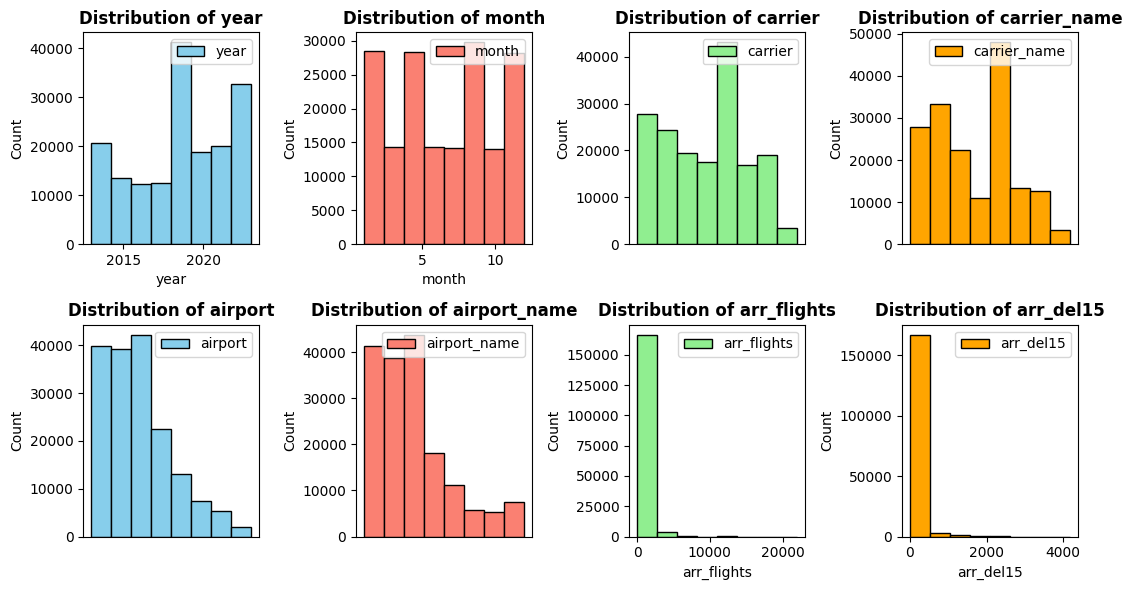

In [9]:
import matplotlib.pyplot as plt

# Considering what's truly present during training / inference is essential, because there's no point 
# wasting our time trying to explore data we won't use.
cols_present_at_inference = [
    'year', 'month', 'carrier', 'carrier_name',
    'airport', 'airport_name', 'arr_flights', 'arr_del15'
]

rows, cols = 2, 4 # We only need 8 plots, so 2 rows 4 cols
fig, axes = plt.subplots(rows, cols, figsize=(11, 6))
axes = axes.flatten()

colors = ["skyblue", "salmon", "lightgreen", "orange"]

# For high cardinality columns, I'd avoid labeling every tick on x-axis to reduce clutter.
high_card_cols = ['carrier_name', 'airport_name', 'airport', 'carrier'] 


for i, (ax, col) in enumerate(zip(axes, cols_present_at_inference)):
    color = colors[i % len(colors)]
    ax.hist(df[col].to_numpy(), bins=8, edgecolor="black", color=color, label=col)
    ax.set_title(f"Distribution of {col}", fontsize=12, fontweight='bold')
    
    ax.set_ylabel("Count")
    
    if col not in high_card_cols:
        ax.set_xlabel(col)
    else:
        ax.set_xticks([]) 

    ax.legend()

for ax in axes[len(cols_present_at_inference):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


#### --> The distributions of most variables are positively skewed, suggesting that a log transformation could help normalize them. However, since there are relatively few outliers, applying a log transformation may not be strictly necessary, especially if outliers are handled or removed beforehand. This indicates that the raw data is already largely representative and transformations might only provide little benefits.

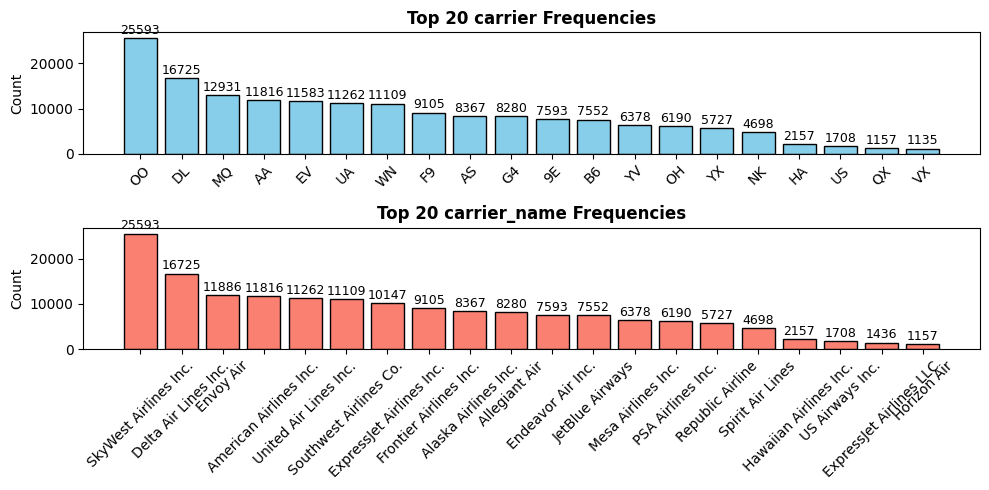

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

carrier_cols = ['carrier', 'carrier_name']
colors = ["skyblue", "salmon"]

fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes = axes.flatten()

for ax, col, color in zip(axes, carrier_cols, colors):
    # Get top 20 most frequent values
    counts = df[col].dropna().value_counts()
    top_counts = counts.head(20)
    
    bars = ax.bar(top_counts.index, top_counts.values, color=color, edgecolor='black')
    
    for bar in bars: # plot each count as a bar
        height = bar.get_height() 
        ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)
    
    ax.set_title(f"Top 20 {col} Frequencies", fontsize=12, fontweight='bold')
    ax.set_ylabel("Count")
    
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
 
for ax in axes[len(carrier_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


### --> Some carriers, like VX, occur relatively infrequently in the dataset. This low representation may limit the model’s ability to accurately learn and capture the true impact of these rare carriers.

### Now that we understand the shapes of our variables, we can move on to understanding relationships.

* How have delays fluctuated throughout the years and month?

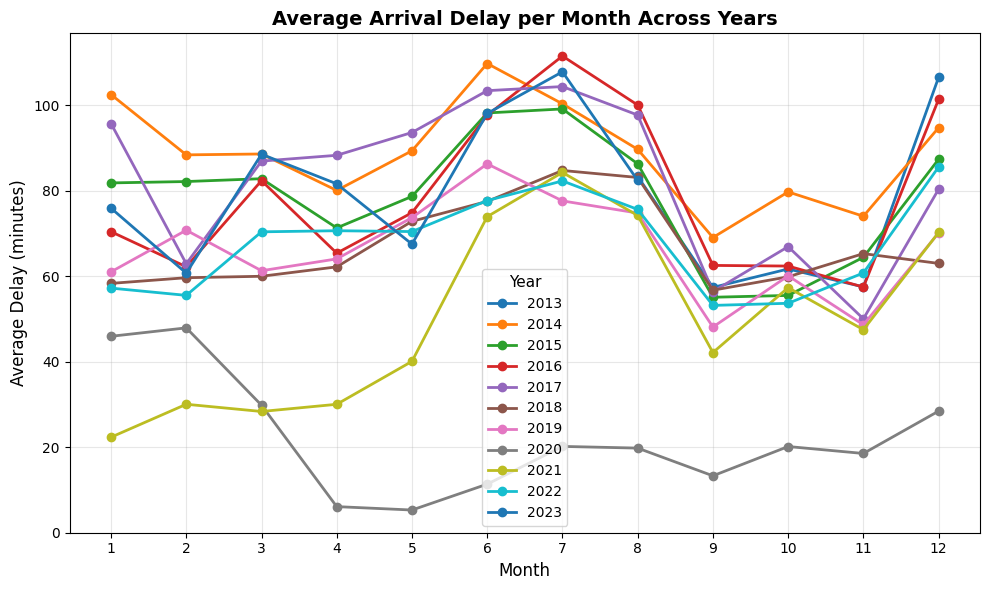

In [ ]:
import matplotlib.pyplot as plt

# Aggregate average delay per month & per year
agg = (
    df.groupby(["year", "month"], as_index=False)["arr_del15"]
      .mean()
      .sort_values(["year", "month"])
)

plt.figure(figsize=(10, 6))

# Plot each year separately
for year, year_data in agg.groupby("year"):
    plt.plot(
        year_data["month"],
        year_data["arr_del15"],  
        marker="o",
        markersize=6,
        linewidth=2,
        label=str(year)
    )

plt.title("Average Arrival Delay per Month Across Years", fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)

plt.xticks(range(1, 13))
plt.grid(alpha=0.3) 
plt.legend(title="Year", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()


#### --> The year 2020 shows a sharp reduction in both flight volume and delays, likely driven by the COVID-19 pandemic. Although a feature like `IsCovid` could help explain this period in hindsight, such events are inherently unpredictable in real-world forecasting and cannot truly be known until they occur.
#### --> Months 6,7 and 8 tend to result in more flights, while months 10, 11 and 9 get the lowest flights.

In [ ]:
# I will add these discoveries as features for modeling, but it is likely true either way
#  that the features 'year' and 'month' capture this effect on their own.
df['isCovid'] = (df['year'] == 2020).astype(int)
df['isPeakSeason'] = df['month'].isin([6, 7, 8]).astype(int)
df['isLowSeason'] = df['month'].isin([9, 10, 11]).astype(int)

* How frequent are delays across airports, relative to that airports' frequency in the dataset?

C:\Users\User\AppData\Local\Temp\ipykernel_17704\2186095169.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_data, x="airport", y="rel_freq", palette="viridis")


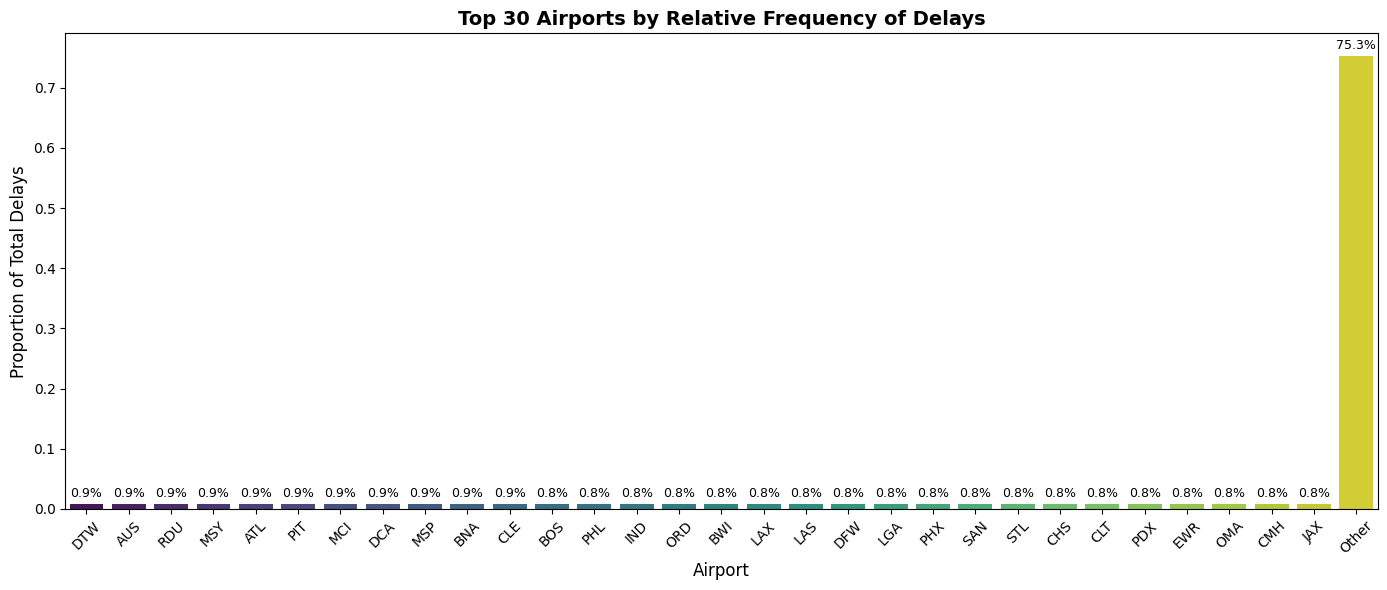

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Aggregate top airports, because there are too many unique values (400+)
df_airport = (
    df.groupby("airport", as_index=False)["arr_del15"]
      .count()
      .rename(columns={"arr_del15": "num_delays"})
      .sort_values("num_delays", ascending=False)
)

top_n = 30
top_airports = df_airport.head(top_n)
other_airports = pd.DataFrame({
    "airport": ["Other"],
    "num_delays": [df_airport["num_delays"].iloc[top_n:].sum()]
})

plot_data = pd.concat([top_airports, other_airports], ignore_index=True)
total_delays = df["arr_del15"].count()
plot_data["rel_freq"] = plot_data["num_delays"] / total_delays

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=plot_data, x="airport", y="rel_freq", palette="viridis")

plt.title(f"Top {top_n} Airports by Relative Frequency of Delays", fontsize=14, fontweight='bold')
plt.xlabel("Airport", fontsize=12)
plt.ylabel("Proportion of Total Delays", fontsize=12)
plt.xticks(rotation=45)

# Annotate bars with relative frequency
for p in ax.patches: 
    height = p.get_height()
    ax.annotate(f'{height:.1%}', 
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center',
                fontsize=9)

plt.tight_layout()
plt.show()


#### --> Specific airports have more delay than others.

#### Our EDA reveals that this dataset is **rich in signal**, in other words, delay isn't the result of random noise. To prepare our dataset for modelling, we must clean it first: 

In [14]:
print(f'{df["carrier_name"].nunique()} unique carrier names, {df["carrier"].nunique()} unique carrier IDs')

23 unique carrier names, 21 unique carrier IDs


#### Since carrier names are more unique, we must rely on them for true carrier uniqueness. With a cardinality of 23, we can encode carrier names.

In [15]:
encoded_carriers = pd.get_dummies(df['carrier_name']) # one-hot encode carrier names
encoded_carriers.replace({True: 1, False: 0},inplace=True) # note: get_dummies() makes the encoding into True:1, False:0
encoded_carriers

df.drop(columns=['carrier_name','carrier'], inplace=True)
df = df.join(encoded_carriers)

C:\Users\User\AppData\Local\Temp\ipykernel_17704\1996882602.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_carriers.replace({True: 1, False: 0},inplace=True)


In [16]:
print(f'{df["airport_name"].nunique()} unique airport names, {df["airport"].nunique()} unique airport IDs')

419 unique airport names, 395 unique airport IDs


#### Same as above, we rely on Airport names. With 400+ unique names, we can either do **target encoding** or **encode the few** that are truly related to more/less delay. 
* note: if you choose to **target encode** be sure to split the df into train & test to **prevent leakage**.
#### We earlier saw that the amount of delays fluctuates with different airports... but **different airports exist in different frequencies, so we need to be sure whether there is a true relationship between specific airports and delay** or whether it's just noise.

In [17]:
# sum up flights & delays per airport
airport_stats = df.groupby('airport_name').agg({
    'arr_del15': 'sum',
    'arr_flights': 'sum',
}).reset_index()

# Calculate delay rate per airport as well as % of total flights
airport_stats['delay_rate'] = airport_stats['arr_del15'] / airport_stats['arr_flights']
airport_stats['pct_of_total_flights'] = airport_stats['arr_flights'] / df['arr_flights'].sum()

# Calculate overall delay rate for later comparisons
overall_delay_rate = df['arr_del15'].sum() / df['arr_flights'].sum()

# How does this airport's delay rate differ from the overall delay rate?
airport_stats['rate_difference'] = abs(airport_stats['delay_rate'] - overall_delay_rate)

# To determine an airport's importance at inference, I multiply how often it shows up by how differnet is it 
# from the overall delay rate. Why? Because an airport that is very different but rare does way less for my
# predictions than one that is.

airport_stats['importance'] = (
    airport_stats['rate_difference'] * 
    airport_stats['pct_of_total_flights']
)

airport_stats = airport_stats.sort_values('importance', ascending=False)

airport_stats.head(20)

,airport_name,arr_del15,arr_flights,delay_rate,pct_of_total_flights,rate_difference,importance
19,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",508434.0,3557460.0,0.142921,0.057243,0.040115,0.002296
269,"Newark, NJ: Newark Liberty International",288816.0,1166485.0,0.247595,0.018770,0.064559,0.001212
340,"San Francisco, CA: San Francisco International",345825.0,1501997.0,0.230243,0.024169,0.047208,0.001141
336,"Salt Lake City, UT: Salt Lake City International",147650.0,1103651.0,0.133783,0.017759,0.049253,0.000875
64,"Charlotte, NC: Charlotte Douglas International",253390.0,1671963.0,0.151552,0.026903,0.031483,0.000847
98,"Detroit, MI: Detroit Metro Wayne County",187536.0,1309481.0,0.143214,0.021071,0.039822,0.000839
241,"Minneapolis, MN: Minneapolis-St Paul Internati...",186133.0,1297444.0,0.143461,0.020877,0.039575,0.000826
268,"New York, NY: LaGuardia",274099.0,1229776.0,0.222885,0.019788,0.039849,0.000789
284,"Orlando, FL: Orlando International",271800.0,1297936.0,0.209409,0.020885,0.026374,0.000551
267,"New York, NY: John F. Kennedy International",226282.0,1064227.0,0.212626,0.017124,0.029590,0.000507


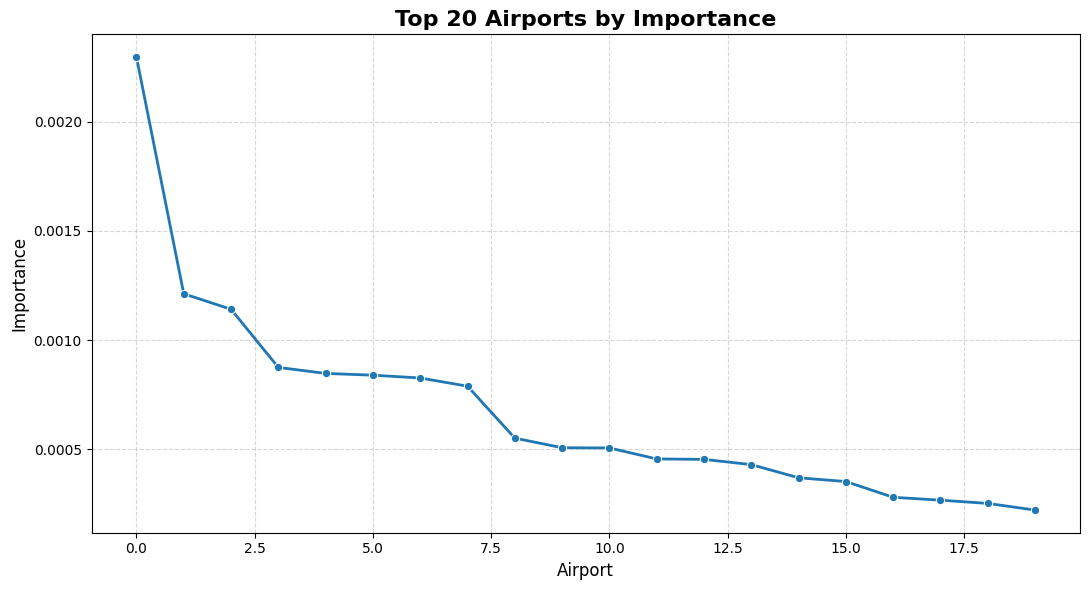

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Take top 20 airports by importance
top_airports = airport_stats.head(20).reset_index(drop=True)

plt.figure(figsize=(11, 6))

sns.lineplot(
    x=top_airports.index,     
    y=top_airports['importance'],
    marker='o',
    linewidth=2,
    markersize=6
)

plt.xticks(top_airports.index, top_airports['airport'], rotation=45, ha='right')

plt.title('Top 20 Airports by Importance', fontsize=16, fontweight='bold')
plt.xlabel('Airport', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Importance Score Analysis:**
After ranking all 419 airports by importance score (effect size × frequency), 
we observe a sharp drop-off after the top few airports:

#### I could one hot encode the top 5 or just the aiport at index 0. The best way to do this is to **try both** and select the best features at inference.

In [19]:
df['is_GA_Atlanta'] = (df['airport_name'] == 'Atlanta, GA: Hartsfield-Jackson Atlanta International').astype(int)

In [ ]:
#  In a production pipeline, we'd put this list in a config file for easy updating.
top_5 = ['Atlanta, GA: Hartsfield-Jackson Atlanta International', 
         'Newark, NJ: Newark Liberty International', 
         'San Francisco, CA: San Francisco International', 
         'Salt Lake City, UT: Salt Lake City International', 
         'Charlotte, NC: Charlotte Douglas International'] 

df['is_top5'] = df['airport_name'].isin(top_5).astype(int)

In [21]:
df.drop(columns=['airport_name','carrier_ct', 'weather_ct',
       'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled',
       'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay',
       'nas_delay', 'security_delay', 'late_aircraft_delay'], inplace=True)

### Null Handling:
* The only variable present at inference a month prior is arr_flights and our target is arr_del15, so these are the only nulls we care about. 

In [22]:
df.columns

Index(['year', 'month', 'airport', 'arr_flights', 'arr_del15', 'isCovid',
       'isPeakSeason', 'isLowSeason', 'AirTran Airways Corporation',
       'Alaska Airlines Inc.', 'Allegiant Air', 'American Airlines Inc.',
       'American Eagle Airlines Inc.', 'Delta Air Lines Inc.',
       'Endeavor Air Inc.', 'Envoy Air', 'ExpressJet Airlines Inc.',
       'ExpressJet Airlines LLC', 'Frontier Airlines Inc.',
       'Hawaiian Airlines Inc.', 'Horizon Air', 'JetBlue Airways',
       'Mesa Airlines Inc.', 'PSA Airlines Inc.', 'Republic Airline',
       'SkyWest Airlines Inc.', 'Southwest Airlines Co.', 'Spirit Air Lines',
       'US Airways Inc.', 'United Air Lines Inc.', 'Virgin America',
       'is_GA_Atlanta', 'is_top5'],
      dtype='object')

In [23]:
df[df[['arr_flights','arr_del15']].isna().any(axis=1)]

,year,month,airport,arr_flights,arr_del15,isCovid,isPeakSeason,isLowSeason,AirTran Airways Corporation,Alaska Airlines Inc.,...,PSA Airlines Inc.,Republic Airline,SkyWest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,is_GA_Atlanta,is_top5
3880,2023,6,CLL,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3894,2023,6,EUG,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3898,2023,6,FSD,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3904,2023,6,GRB,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3910,2023,6,HPN,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168602,2013,10,LSE,NaN,NaN,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
169464,2013,9,MTJ,NaN,NaN,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
170096,2013,9,FAY,NaN,NaN,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
170150,2013,9,TPA,1.0,NaN,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### For such a relatively small count nulls compared to the entire count of rows, dropping the nulls is acceptable because **I would rather not impute the target**. If I had to, I'd impute with the mean as arr_del15 isn't significanftly skewed.

In [24]:
df = df.dropna(subset=['arr_del15'])

In [25]:
df[['arr_flights','arr_del15']].isna().sum()

arr_flights    0
arr_del15      0
dtype: int64

#### --> The null rows were overlapping between both features and we were right to drop them as they have been reduced to 0 for both columns.

### Outlier Handling:

In [28]:
df[['arr_flights','arr_del15']].describe()

,arr_flights,arr_del15
count,171223.000000,171223.000000
mean,362.946427,66.434387
std,993.408638,179.540694
min,1.000000,0.000000
25%,50.000000,6.000000
50%,101.000000,17.000000
75%,250.000000,47.000000
max,21977.000000,4176.000000


In [33]:
# let's start off by getting the outliers in arr_flights
Q1 = df['arr_flights'].quantile(0.25)
Q3 = df['arr_flights'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
arr_flights_outliers = df[(df['arr_flights'] < lower_bound) | (df['arr_flights'] > upper_bound)]
arr_flights_outliers

,year,month,airport,arr_flights,arr_del15,isCovid,isPeakSeason,isLowSeason,AirTran Airways Corporation,Alaska Airlines Inc.,...,PSA Airlines Inc.,Republic Airline,SkyWest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,is_GA_Atlanta,is_top5
5,2023,8,ATL,1636.0,256.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
27,2023,8,CVG,637.0,109.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,2023,8,DTW,1607.0,262.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,2023,8,JFK,1576.0,213.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54,2023,8,LGA,3171.0,438.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171586,2013,8,CLT,3309.0,677.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
171595,2013,8,HNL,591.0,284.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171597,2013,8,IAD,914.0,178.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171617,2013,8,ORD,892.0,173.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# let's start off by getting the outliers in arr_del15
# Mathematically, the outlier is calculated  using IQR (Interquartile Range) method; Where the lower 
# bound is Q1 - 1.5*IQR and upper bound is Q3 + 1.5*IQR. A value below the lower bound or above the 
# upper bound is considered an outlier.

Q1 = df['arr_del15'].quantile(0.25)
Q3 = df['arr_del15'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
arr_del15_outliers = df[(df['arr_del15'] < lower_bound) | (df['arr_del15'] > upper_bound)]
arr_del15_outliers

,year,month,airport,arr_flights,arr_del15,isCovid,isPeakSeason,isLowSeason,AirTran Airways Corporation,Alaska Airlines Inc.,...,PSA Airlines Inc.,Republic Airline,SkyWest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,is_GA_Atlanta,is_top5
5,2023,8,ATL,1636.0,256.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
27,2023,8,CVG,637.0,109.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,2023,8,DTW,1607.0,262.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,2023,8,JFK,1576.0,213.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54,2023,8,LGA,3171.0,438.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171584,2013,8,PIT,535.0,164.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
171586,2013,8,CLT,3309.0,677.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
171595,2013,8,HNL,591.0,284.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171597,2013,8,IAD,914.0,178.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Unlike nulls, the outliers are substantial and cannot be removed. **We would lose to much data**. 
* I have chosen not to cap or remove outliers, so I will **log transform arr_flights** and keep the target as is, relying on robust  models such as tree based models or Huber Regression at inference.

In [34]:
df['arr_flights'] = np.log(df['arr_flights'])

### Final look and evaluation:

In [35]:
df

,year,month,airport,arr_flights,arr_del15,isCovid,isPeakSeason,isLowSeason,AirTran Airways Corporation,Alaska Airlines Inc.,...,PSA Airlines Inc.,Republic Airline,SkyWest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,is_GA_Atlanta,is_top5
0,2023,8,ABE,4.488636,13.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023,8,ABY,4.127134,10.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023,8,AEX,4.127134,10.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023,8,AGS,4.189655,12.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023,8,ALB,4.521789,22.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171661,2013,8,TRI,1.945910,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171662,2013,8,YUM,0.693147,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171663,2013,8,SLC,0.693147,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
171664,2013,8,SBN,0.000000,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### We have made many necessary changes to the dataset and now understand it fully. In 02_modelling.ipynb I will start training  models to predict arr_del15, selecting **some or all of these features**, depending on the best performing option.